# Question (2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/NLP_CA2_2/sarcasm.json"

import pandas as pd
import json

# Load the JSON file
with open(data_path) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = text.split()
    # tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

df['headline2'] = df['headline'].apply(preprocess_text)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,is_sarcastic,headline,article_link,headline2
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...


In [ ]:
print('has sarcastics : ')
print(df['is_sarcastic'].value_counts()[1])

print('--------------------')

print('non sarcastics : ')
print(df['is_sarcastic'].value_counts()[0])

has sarcastics : 
13634
--------------------
non sarcastics : 
14985


**Now, all_texts variable contains all the headline texts concatenated into a single string**

In [ ]:
# Initialize an empty list to store the headline texts
texts = []
all_words_set = set()

# Iterate over each row in the DataFrame and append the headline text to the list
for index, row in df.iterrows():
    texts.append(row['headline2'])

    if index < 20:
      # print(f'headline2 : { row[\'headline2\'] }  is_sarcasm :
      print(row['is_sarcastic'])
      print(row['headline2'])
      print('------------------------------')

    for word in row['headline2']:
      if word not in all_words_set:
        all_words_set.add(word)

# Join the texts in the list to create a single string
all_texts = ' '.join(texts)

**Download Glove.6B.zip**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer

# Assuming 'texts' is a list of input texts for training the tokenizer
tokenizer = Tokenizer()
# tokenizer.fit_on_texts(all_texts)
tokenizer.fit_on_texts(all_words_set)

embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')

        if word in ['do' , 'does' , 'doing' , 'done']:
          print(word)
          print(coefs)
          print('---------------------------')
        embeddings_index[word] = coefs

embedding_dim = 100
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        print(f'Word not found in GloVe embeddings: {word}')

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train, X_eval, y_train, y_eval = train_test_split(df['headline2'], df['is_sarcastic'], test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score
from sklearn.model_selection import train_test_split

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_eval)

# Convert sequences to padded sequences
max_length = 100  # Define a maximum sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Create feature matrices using the embedding matrix
X_train_features = np.array([embedding_matrix[x] for x in X_train_padded])
X_test_features = np.array([embedding_matrix[x] for x in X_test_padded])

# Define and train the logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_features.reshape(X_train_features.shape[0], -1), y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_features.reshape(X_test_features.shape[0], -1))

# Evaluate the model
accuracy = accuracy_score(y_eval , y_pred)
precision = precision_score(y_eval , y_pred)
recall = recall_score(y_eval , y_pred)
f1 = f1_score(y_eval , y_pred)

print(f'Accuracy  : {accuracy}')
print(f'precision : {precision}')
print(f'recall    : {recall}')
print(f'f1        : {f1}')

Accuracy  : 0.556953179594689
precision : 0.5202773691952091
recall    : 0.907292048369366
f1        : 0.6613247863247863


**Using LSTM neural network**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs = 20, batch_size=200)

# Evaluate the model
accuracy = model.evaluate(X_test_padded, y_eval)[1]

print(f'Accuracy: {accuracy}')


Epoch 1/20
115/115 [==============================] - 46s 382ms/step - loss: 0.6740 - accuracy: 0.5440
Epoch 2/20
115/115 [==============================] - 44s 380ms/step - loss: 0.6704 - accuracy: 0.5509
Epoch 3/20
115/115 [==============================] - 41s 357ms/step - loss: 0.6699 - accuracy: 0.5510
Epoch 4/20
115/115 [==============================] - 50s 435ms/step - loss: 0.6693 - accuracy: 0.5515
Epoch 5/20
115/115 [==============================] - 41s 361ms/step - loss: 0.6688 - accuracy: 0.5521
Epoch 6/20
115/115 [==============================] - 47s 411ms/step - loss: 0.6684 - accuracy: 0.5515
Epoch 7/20
115/115 [==============================] - 39s 337ms/step - loss: 0.6680 - accuracy: 0.5524
Epoch 8/20
115/115 [==============================] - 46s 397ms/step - loss: 0.6677 - accuracy: 0.5521
Epoch 9/20
115/115 [==============================] - 41s 359ms/step - loss: 0.6675 - accuracy: 0.5526
Epoch 10/20
115/115 [==============================] - 43s 376ms/step - l

# Question (3)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = "/content/drive/MyDrive/NLP_CA2_2/advs.txt"

with open(data_path, 'r') as data_file:
    text_data = data_file.read()

# text_data

In [6]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Preprocessing function with stopwords removal and stemming
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize the text
    tokens = text.split()

    # Remove stopwords and apply stemming
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

    return tokens

# Read the text data
data_path = "/content/drive/MyDrive/NLP_CA2_2/advs.txt"

with open(data_path, 'r') as data_file:
    text_data = data_file.read()

# Preprocess the text data
tokens = preprocess_text(text_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
uncl_count = tokens.count('uncle')
aunt_count = tokens.count('aunt')

brother_count = tokens.count('brother')
sister_count  = tokens.count('sister')

print(f'uncle : {uncl_count} \n aunt : {aunt_count} \n brother : {brother_count} \n sister : {sister_count}')

**train skipgram model**

In [14]:
from collections import defaultdict
import numpy as np

def negative_sampling(context_vector, target_vector, context_word , target_word , epochs , learning_rate=0.01):
    positive_score = np.dot(context_vector, target_vector)
    negative_samples = np.random.choice(list(word_to_index.values()), size=5, replace=False)

    for neg_sample in negative_samples:
        neg_score = np.dot(context_vector, context_vectors[neg_sample])
        neg_gradient = 1 / (1 + np.exp(neg_score))
        context_vectors[neg_sample] -= learning_rate * neg_gradient * context_vector

    pos_gradient = 1 / (1 + np.exp(-positive_score))
    target_vector -= learning_rate * pos_gradient * context_vector

    similarity = np.dot(context_vector, target_vector)

    if similarity > 10 and context_word != target_word and epochs > 40 :
      print(f'similarity of {context_word} and {target_word} is : {similarity}')

# Create word to index mapping
word_to_index = {word: idx for idx, word in enumerate(set(tokens))}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Create context windows
window_size = 2
context_windows = []
for i in range(len(tokens)):
    for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
        if i != j:
            context_windows.append((word_to_index[tokens[i]], word_to_index[tokens[j]]))

# Initialize embedding vectors and context vectors
embedding_dim = 100
embedding_vectors = np.random.uniform(-1, 1, (len(word_to_index), embedding_dim))
context_vectors = np.random.uniform(-1, 1, (len(word_to_index), embedding_dim))


num_epochs = 125

for epoch in range(num_epochs):
    if epoch % 20 == 0:
      print(f'epoch : {epoch}')
      print('-----------------------------')
    for context, target in context_windows:
        context_vector = embedding_vectors[context]
        target_vector = embedding_vectors[target]

        # print(f'context : {index_to_word[context]} , target : {index_to_word[target]}')

        negative_sampling(context_vector, target_vector , index_to_word[context] , index_to_word[target] , epoch)

epoch : 0
-----------------------------


KeyboardInterrupt: 

**section 2**

In [12]:
# Get the indices of the words
queen_idx = word_to_index["queen"]
king_idx = word_to_index["king"]
man_idx = word_to_index["man"]
woman_idx = word_to_index["woman"]

# Calculate the new vector: king - man + woman
result_vector = embedding_vectors[king_idx] - embedding_vectors[man_idx] + embedding_vectors[woman_idx]

# Calculate the similarity using inner product
similarity = np.dot(embedding_vectors[queen_idx], result_vector)

print("Similarity between 'queen' and (king - man + woman) vector:", similarity)

Similarity between 'queen' and (king - man + woman) vector: 4.686351127977175


**section 3 (PCA Transformation)**

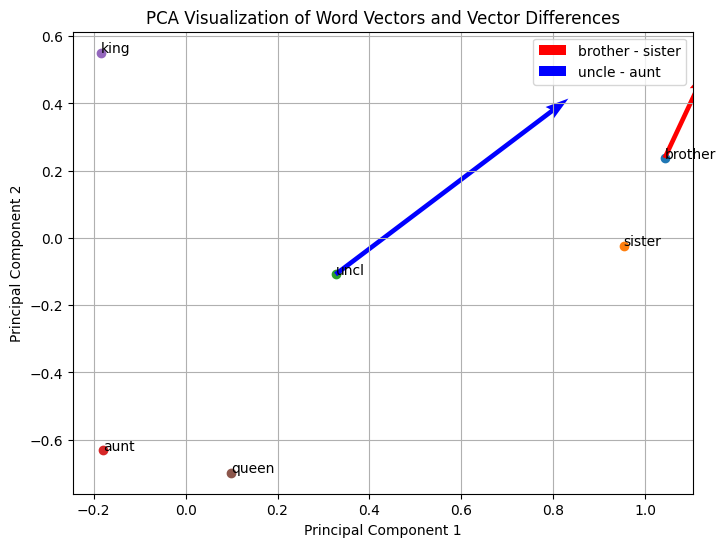

In [15]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA transformation
pca = PCA(n_components=2)
embedding_vectors_2d = pca.fit_transform(embedding_vectors)

# Visualize the feature vectors of words in two dimensions
words_to_plot = ["brother", "sister", "uncl", "aunt" , "king" , "queen"]
indices_to_plot = [word_to_index[word] for word in words_to_plot]

plt.figure(figsize=(8, 6))
for idx in indices_to_plot:
    plt.scatter(embedding_vectors_2d[idx, 0], embedding_vectors_2d[idx, 1])
    plt.annotate(index_to_word[idx], (embedding_vectors_2d[idx, 0], embedding_vectors_2d[idx, 1]))

# Calculate and visualize the vectors (brother - sister) and (uncle - aunt)
brother_idx = word_to_index["brother"]
sister_idx = word_to_index["sister"]
uncle_idx = word_to_index["uncl"]
aunt_idx = word_to_index["aunt"]

king_idx = word_to_index["king"]
queen_idx = word_to_index["queen"]

vector_bro_sis = embedding_vectors_2d[brother_idx] - embedding_vectors_2d[sister_idx]
vector_unc_aunt = embedding_vectors_2d[uncle_idx] - embedding_vectors_2d[aunt_idx]

plt.quiver(embedding_vectors_2d[brother_idx, 0], embedding_vectors_2d[brother_idx, 1], vector_bro_sis[0], vector_bro_sis[1], angles='xy', scale_units='xy', scale=1, color='r', label='brother - sister')
plt.quiver(embedding_vectors_2d[uncle_idx, 0], embedding_vectors_2d[uncle_idx, 1], vector_unc_aunt[0], vector_unc_aunt[1], angles='xy', scale_units='xy', scale=1, color='b', label='uncle - aunt')

plt.legend()
plt.title("PCA Visualization of Word Vectors and Vector Differences")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()